In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from src.scDiffusion import VAE, guided_diffusion
from src.scDiffusion.VAE.VAE_model import *
import glob

In [2]:
adata = sc.read_h5ad("../data/thymocyte.h5ad")

In [3]:
adata.obs['cell_type'].cat.categories.tolist()

['DP', 'Immature\n CD8', 'Mature\n CD8']

In [4]:
adata.obs["celltype"] = adata.obs["cell_type"].map(
    {"DP": "DP", "Immature\n CD8": "ImmatureCD8", "Mature\n CD8": "MatureCD8"}
)
adata.obs["celltype"] = adata.obs["celltype"].astype("category")

In [5]:
adata.obs["period"] = adata.obs["celltype"]

In [8]:
adata.write("../data/thy_diff.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 19744 × 2000
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins', 'batch', 'leiden_totalVI_res1.4', 'leiden_totalVI_res1.0', 'leiden_totalVI_res0.6', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', 'ADT_CD14_A0424_fore_prob', 'ADT_CD14_A0424', 'ADT_CD15(SSEA-1)_A

### Train the SCimilarity VAE

In [10]:
!python ../src/scDiffusion/VAE/VAE_train.py \
--data_dir '../data/thy_diff.h5ad' \
--num_genes 2000 \
--save_dir '../models/scdiff/thy/VAE' \
--state_dict '../models/scdiff/annotation_model_v1/' \
--max_steps 200000


loading pretrained model from: 
 {'encoder': '../models/scdiff/annotation_model_v1/encoder.ckpt', 'decoder': '../models/scdiff/annotation_model_v1/decoder.ckpt', 'gene_order': '../models/scdiff/annotation_model_v1/gene_order.tsv'}
step  0 loss  1.323831558227539
step  1000 loss  0.4522284269332886
step  2000 loss  0.4366207420825958
step  3000 loss  0.4143854081630707
step  4000 loss  0.4094083607196808
step  5000 loss  0.4006950259208679
step  6000 loss  0.4076257646083832
step  7000 loss  0.3900565505027771
step  8000 loss  0.3846350312232971
step  9000 loss  0.3800831437110901
step  10000 loss  0.37712639570236206
step  11000 loss  0.3764079213142395
step  12000 loss  0.36932626366615295
step  13000 loss  0.365014910697937
step  14000 loss  0.371807336807251
step  15000 loss  0.362415075302124
step  16000 loss  0.3570358157157898
step  17000 loss  0.35120153427124023
step  18000 loss  0.3562745451927185
step  19000 loss  0.34603121876716614
step  20000 loss  0.34808868169784546
step

### Train the diffusion backbone

In [6]:
!python ../src/scDiffusion/cell_train.py \
  --data_dir '../data/thy_diff.h5ad' \
  --vae_path '../models/scdiff/thy/VAE/model_seed=0_step=199999.pt' \
  --model_name 'diffusion' \
  --save_dir '../models/scdiff/thy' \
  --batch_size 128 \
  --lr 0.5e-5 \
  --lr_anneal_steps 20000

Logging to ../models/scdiff/emt/diffusion/logs/diffusion
creating model and diffusion...
creating data loader...
training...
-------------------------
| grad_norm  | 0.863    |
| loss       | 1.12     |
| loss_q0    | 1.19     |
| loss_q1    | 1.11     |
| loss_q2    | 1.27     |
| loss_q3    | 1.28     |
| mse        | 1.12     |
| mse_q0     | 1.19     |
| mse_q1     | 1.11     |
| mse_q2     | 1.27     |
| mse_q3     | 1.28     |
| param_norm | 79       |
| samples    | 128      |
| step       | 0        |
-------------------------
saving model 0...
saving model 0.9999...
-------------------------
| grad_norm  | 0.638    |
| loss       | 1.02     |
| loss_q0    | 0.954    |
| loss_q1    | 1.17     |
| loss_q2    | 1.08     |
| loss_q3    | 0.97     |
| mse        | 1.02     |
| mse_q0     | 0.954    |
| mse_q1     | 1.17     |
| mse_q2     | 1.08     |
| mse_q3     | 0.97     |
| param_norm | 79       |
| samples    | 1.29e+04 |
| step       | 100      |
-------------------------
--

In [6]:
device     = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
num_cells, num_genes = adata.shape

In [7]:
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

In [8]:
latent_dim = 128  

model = VAE(
    num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
state = torch.load('../models/scdiff/thy/VAE/model_seed=0_step=199999.pt', map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

VAE(
  (encoder): Encoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=2000, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (

In [9]:
X_latent = np.zeros((num_cells, latent_dim), dtype=np.float32)

with torch.no_grad():
    for start in range(0, num_cells, batch_size):
        end = min(start + batch_size, num_cells)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)

        z = model.encoder(batch)    

        X_latent[start:end] = z.cpu().numpy()

### Train the classifier

In [7]:
!python ../src/scDiffusion/classifier_train.py \
  --data_dir '../data/thy_diff.h5ad' \
  --vae_path '../models/scdiff/thy/VAE/model_seed=0_step=199999.pt' \
  --model_path '../models/scdiff/thy/classifier/' \
  --num_class 3 \
  --batch_size 64 \
  --iterations 10000 \
  --lr 1e-3 \
  --weight_decay 0.0 \
  --log_interval 100 \
  --save_interval 1000 \
  --noised False

Logging to /tmp/openai-2025-12-11-14-48-27-421313
creating model and diffusion...
Running in single GPU mode without DDP
creating data loader...
creating optimizer...
training classifier model...
-----------------------------
| grad_norm      | 3.39     |
| param_norm     | 49.8     |
| samples        | 64       |
| step           | 0        |
| train_acc@1    | 0.234    |
| train_acc@1_q0 | 0        |
| train_loss     | 1.15     |
| train_loss_q0  | 1.09     |
-----------------------------
-----------------------------
| grad_norm      | 1.19     |
| param_norm     | 50.1     |
| samples        | 6.46e+03 |
| step           | 100      |
| train_acc@1    | 0.828    |
| train_acc@1_q0 | 1        |
| train_loss     | 0.328    |
| train_loss_q0  | 0.0021   |
-----------------------------
-----------------------------
| grad_norm      | 0.866    |
| param_norm     | 50.3     |
| samples        | 1.29e+04 |
| step           | 200      |
| train_acc@1    | 0.969    |
| train_acc@1_q0 | 1    

### Generate Trajectory

In [30]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
le.fit(adata.obs["celltype"]) 
print(le.classes_)

['DP' 'ImmatureCD8' 'MatureCD8']


In [31]:
!python ../src/scDiffusion/classifier_sample.py 

Logging to /tmp/openai-2025-12-12-01-11-25-840211
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_0.npz
sampling complete
Logging to /tmp/openai-2025-12-12-01-11-33-703544
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_1.npz
sampling complete
Logging to /tmp/openai-2025-12-12-01-11-37-196326
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_2.npz
sampling complete
Logging to /tmp/ope

In [32]:
paths = sorted(
    glob.glob("../data/generated/interpolation_*.npz"),
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)
paths

['../data/generated/interpolation_0.npz',
 '../data/generated/interpolation_1.npz',
 '../data/generated/interpolation_2.npz',
 '../data/generated/interpolation_3.npz',
 '../data/generated/interpolation_4.npz',
 '../data/generated/interpolation_5.npz',
 '../data/generated/interpolation_6.npz',
 '../data/generated/interpolation_7.npz',
 '../data/generated/interpolation_8.npz',
 '../data/generated/interpolation_9.npz',
 '../data/generated/interpolation_10.npz']

In [33]:
Z_list = []
step_list = []

for i, path in enumerate(paths):
    d = np.load(path)
    z_i = d["cell_gen"]          
    Z_list.append(z_i)
    step_list.append(np.full(z_i.shape[0], i, dtype=int))  

Z = np.vstack(Z_list)            
steps = np.concatenate(step_list)

In [34]:
N_target = 200
N_total = Z.shape[0]

idx = np.linspace(0, N_total - 1, N_target).astype(int)

Z = Z[idx]

In [35]:
with torch.no_grad():
    z_t = torch.tensor(Z, dtype=torch.float32, device=device)

    X_syn = model.decoder(z_t)

    X_syn = X_syn.cpu().numpy() 

In [36]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [37]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [38]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


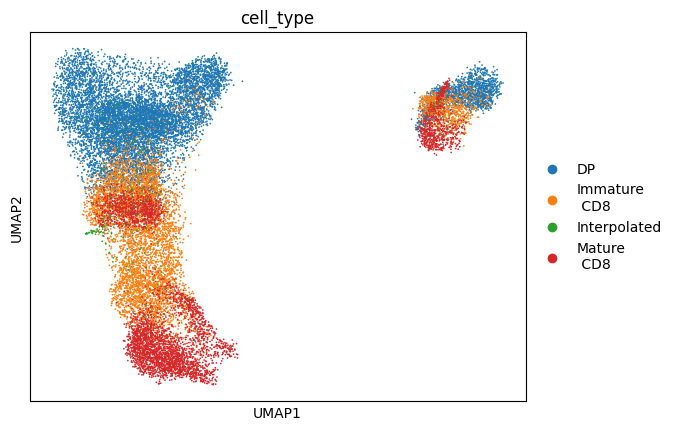

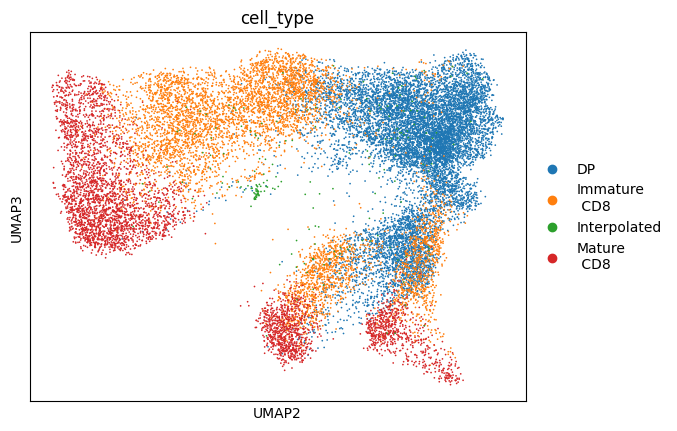

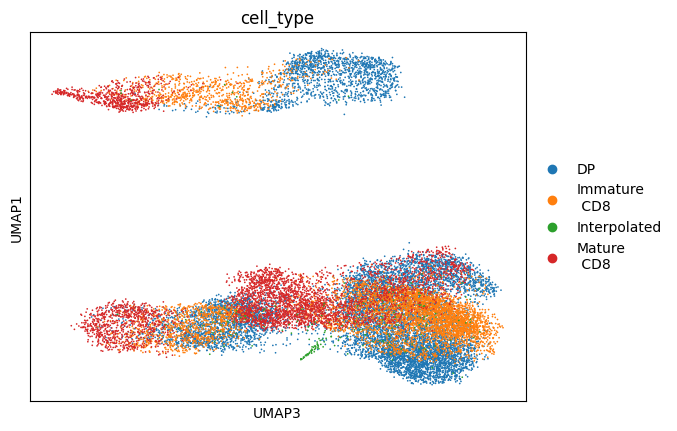

In [39]:
plot_umap(combined_adata, 'cell_type')

In [40]:
adata.var_names = adata.var_names.str.upper()
adata.var.index = adata.var_names
adata.var['gene_short_name'] = adata.var.index

Available dp markers: ['RAG1', 'RAG2', 'DNTT']
Available immature cd4 markers: ['TRAC', 'TRBC1', 'CD69']
Available mature cd4 markers: ['IL7R', 'CCR7', 'LST1']


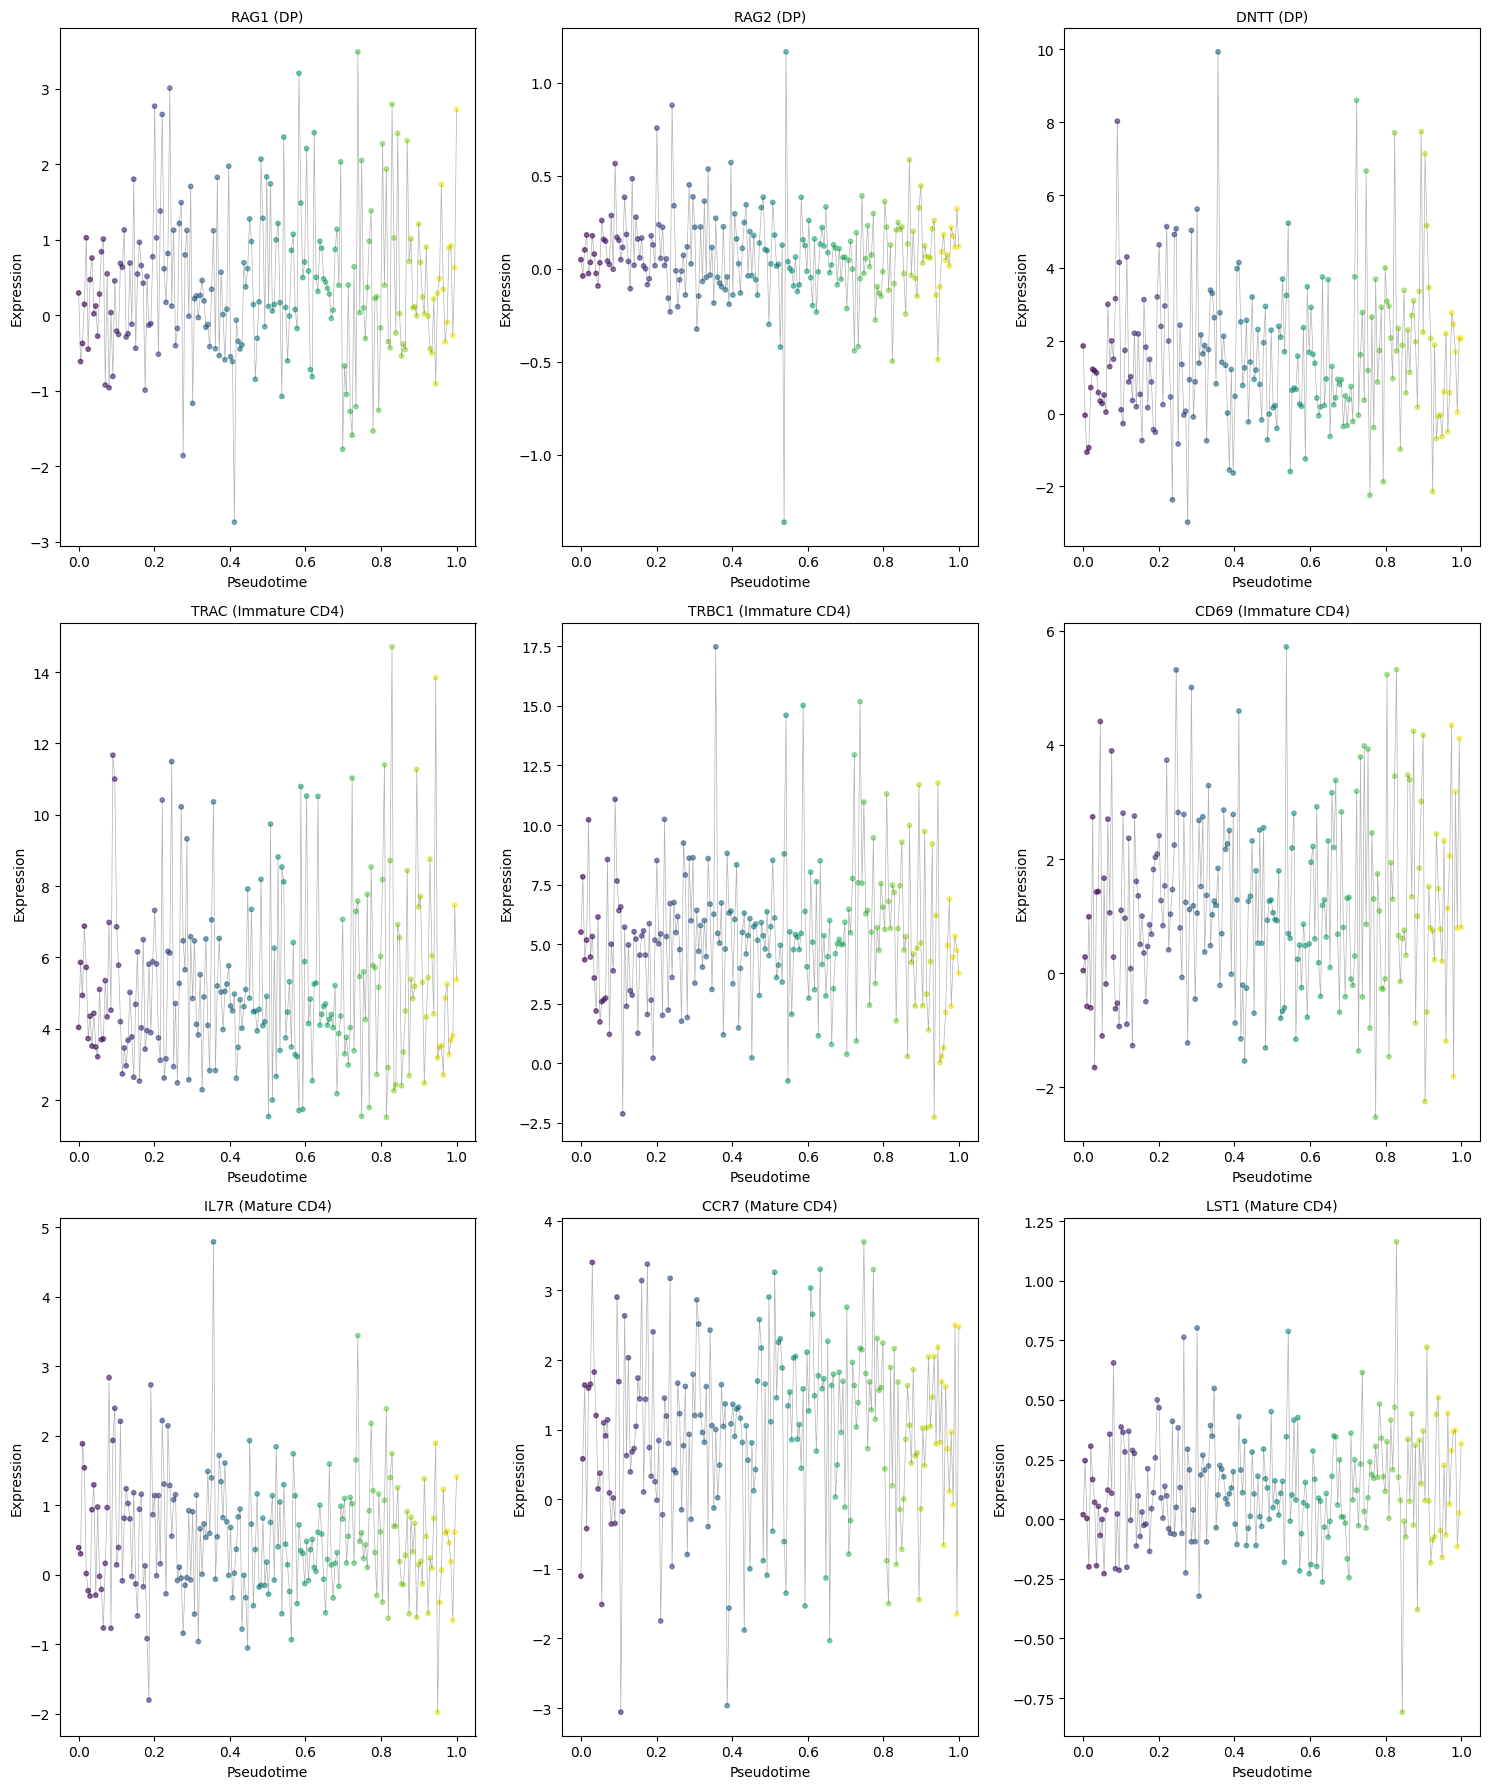

In [41]:
dp_markers = ['RAG1', 'RAG2', 'DNTT']
immature_cd4_markers = ['TRAC', 'TRBC1', 'CD69']
mature_cd4_markers = ['IL7R', 'CCR7', 'LST1']

gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_dp = [g for g in dp_markers if g in gene_names]
available_immature_cd4 = [g for g in immature_cd4_markers if g in gene_names]
available_mature_cd4 = [g for g in mature_cd4_markers if g in gene_names]

print(f"Available dp markers: {available_dp}")
print(f"Available immature cd4 markers: {available_immature_cd4}")
print(f"Available mature cd4 markers: {available_mature_cd4}")

if available_dp or available_immature_cd4 or available_mature_cd4:
    n_markers = len(available_dp) + len(available_immature_cd4) + len(available_mature_cd4)
    n_cols = 3
    n_rows = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,len(X_syn))
    
    plot_idx = 0
    for gene in available_dp:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (DP)', fontsize=10)
        plot_idx += 1
    
    for gene in available_immature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Immature CD4)', fontsize=10)
        plot_idx += 1

    for gene in available_mature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mature CD4)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No common markers found in the dataset")

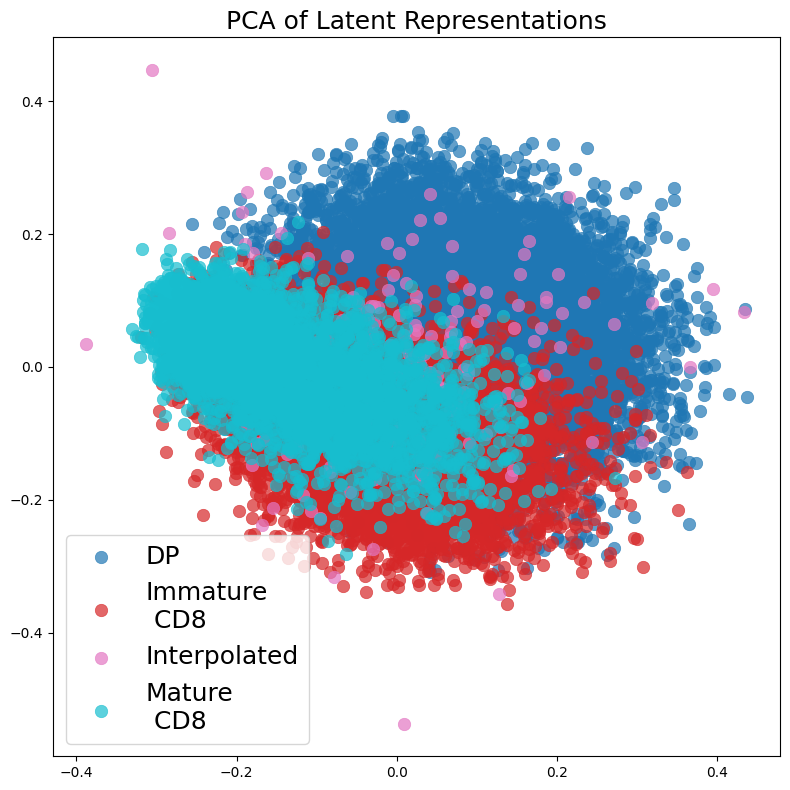

In [42]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}
# figsize
plt.figure(figsize=(8,8))
for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


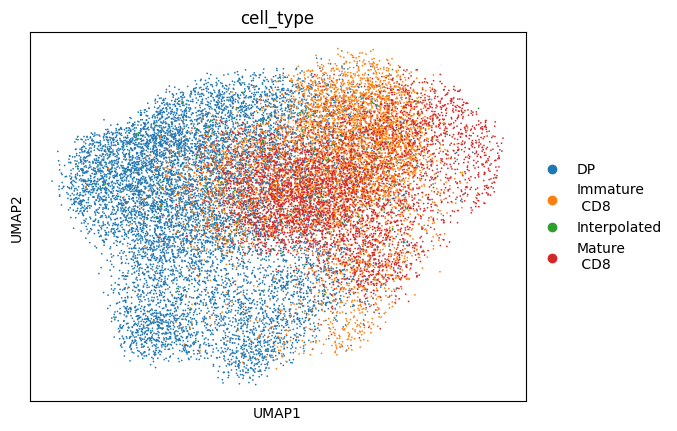

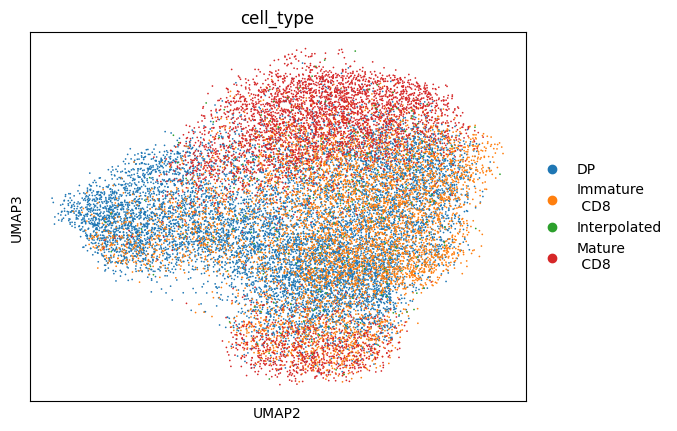

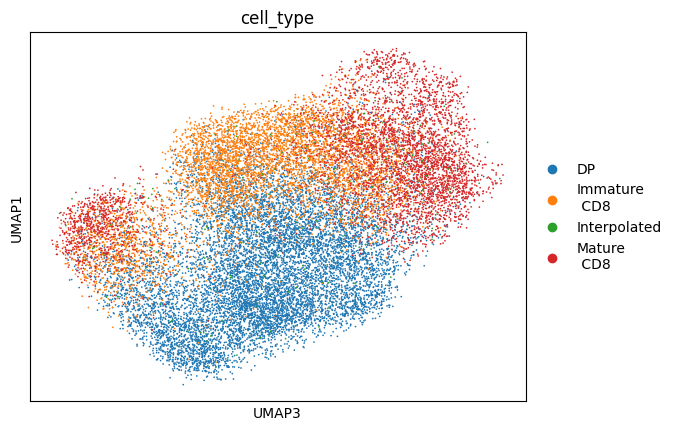

In [43]:
adata_latent_syn = anndata.AnnData(Z)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [44]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, len(X_syn)),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.2731363687986256, 'delta_t_median': 0.24875916817679478, 'delta_t_max': 0.7190250787303676, 'dist_mean': 43.248118047714236, 'dist_median': 38.62272834777832, 'dist_max': 110.52350616455078}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.692375,0.692375,31.820353
1,0.005025,0.255396,0.250371,43.929771
2,0.010050,0.615767,0.605717,30.768379
3,0.015075,0.598436,0.583360,45.686825
4,0.020101,0.598436,0.578335,60.280262


In [45]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 43.248118047714236, 'dist_median': 38.62272834777832, 'dist_max': 110.52350616455078, 'smooth_mean_abs_delta': 12.279862667447958, 'smooth_max_abs_delta': 75.41662979125977}


In [46]:
marker_sets = {
    "DP": ['RAG1', 'RAG2', 'DNTT'],
    "Immature CD4": ['TRAC', 'TRBC1', 'CD69'],
    "Mature CD4": ['IL7R', 'CCR7', 'LST1']
}

expected_directions = {
    "DP": -1,   
    "Immature CD4": 1,   
    "Mature CD4": 1,   
}

df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, 200),      
    gene_list=list(gene_names),
    marker_sets=marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()


          group  n_genes  mean_rho  median_rho  frac_sign_ok
0            DP        3  0.020152    0.037121      0.333333
1  Immature CD4        3  0.031052    0.028009      1.000000
2    Mature CD4        3  0.048774    0.081455      0.666667


,group,gene,rho,pval,expected_dir,sign_ok
0,DP,RAG1,0.037121,0.601764,-1,False
1,DP,RAG2,-0.043023,0.545247,-1,True
2,DP,DNTT,0.066356,0.350532,-1,False
3,Immature CD4,TRAC,0.023798,0.738007,1,True
4,Immature CD4,TRBC1,0.028009,0.693805,1,True


In [29]:
adata_interpolated_cells.write_h5ad('../data/syn_thy_scdiff.h5ad')